# Mapping school data

In this notebook, we will merged the clean School-Level Master File (SCHMA) data, expenditure report data, and school demographic and accountability data, then begin exploring spatial patterns in the data by mapping.

First, we load the data:

In [65]:
import pandas as pd
import numpy as np

In [66]:
data_2010 = pd.read_csv('../../data/merged_data/expenditure_demo_account_year_2010.csv', index_col=0)
data_2011 = pd.read_csv('../../data/merged_data/expenditure_demo_account_year_2011.csv', index_col=0)
data_2012 = pd.read_csv('../../data/merged_data/expenditure_demo_account_year_2012.csv', index_col=0)

all_years_data = {2010: data_2010, 2011: data_2011, 2012: data_2012}

SCHMA = pd.read_csv('../../data/clean_SCHMA.csv', index_col=0).reset_index(drop=True)

In [67]:
SCHMA.head(6)

,YEAR,LCGGEOX,LCGGEOY,BNLONG
0,2010,-73.9793,40.72200,M015
1,2010,-73.9838,40.72964,M019
2,2010,-73.9866,40.72137,M020
3,2010,-73.9753,40.72647,M034
4,2010,-73.9863,40.72417,M063
5,2010,-73.9816,40.72441,M064


Before we merge the data, we normalize all the expenditure data by the total per student expenditures at a school.

In [68]:
for year in all_years_data:
    print all_years_data[year].shape
    ##Drop non-expenditure and non-numeric fields, then normalize
    numeric = all_years_data[year].drop(['School','District','Title_1','DBN', 'Name', 'schoolyear',
                                         'fl_percent', 'frl_percent', 'total_enrollment', 'ell_percent',
                                         'sped_percent', 'asian_per', 'black_per', 'hispanic_per', 'white_per',
                                         'male_per', 'female_per', 'poverty_level', 'elementary_school',
                                         'middle_school', 'high_school'], axis=1)
    numeric = numeric.div(numeric.Total, axis='index')
    
    ##Concatenate back together
    all_years_data[year] = pd.concat([all_years_data[year][['School','District','Title_1','DBN', 'Name', 'schoolyear',
                                                           'fl_percent', 'frl_percent', 'total_enrollment', 'ell_percent',
                                                           'sped_percent', 'asian_per', 'black_per', 'hispanic_per', 'white_per',
                                                           'male_per', 'female_per', 'poverty_level', 'elementary_school',
                                                           'middle_school', 'high_school']], numeric], axis=1)
    
    #Finally merge in SCHMA lat/long coordinates
    all_years_data[year] = pd.merge(all_years_data[year], SCHMA[SCHMA['YEAR'] == year], how='inner', left_index=True, right_on='BNLONG')
    all_years_data[year].set_index(all_years_data[year].BNLONG, inplace=True)
    all_years_data[year].drop(['YEAR','BNLONG'], axis=1, inplace=True)
    print all_years_data[year].shape

(1472, 71)
(1472, 73)
(1497, 71)
(1497, 73)
(1508, 69)
(1508, 71)


Again, let's check for missing values:

In [69]:
for year in all_years_data:
    print '\nYear = ', str(year)
    print 'Number observations', len(all_years_data[year])
    print 'Missing variable counts:', all_years_data[year].drop(['fl_percent', 'frl_percent'],axis=1).isnull().sum().sum()


Year =  2010
Number observations 1472
Missing variable counts: 0

Year =  2011
Number observations 1497
Missing variable counts: 0

Year =  2012
Number observations 1508
Missing variable counts: 0


And that the expenditure features are now normed:

In [75]:
for year in all_years_data:
    num_greater_1 = (all_years_data[year].drop(['School','District','Title_1','DBN', 'Name', 'schoolyear',
                                         'fl_percent', 'frl_percent', 'total_enrollment', 'ell_percent',
                                         'sped_percent', 'asian_per', 'black_per', 'hispanic_per', 'white_per',
                                         'male_per', 'female_per', 'poverty_level', 'elementary_school',
                                         'middle_school', 'high_school', 'LCGGEOY', 'LCGGEOX'], axis=1).max() > 1).sum()
    print 'For {} the number of expenditure features greater than 1 is {}'.format(year, num_greater_1)

For 2010 the number of expenditure features greater than 1 is 0
For 2011 the number of expenditure features greater than 1 is 0
For 2012 the number of expenditure features greater than 1 is 0


Now we're ready to begin plotting maps.

In [76]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-8271038.16594,4931552.16054,-8202020.08165,5004969.47023&bboxSR=3857&imageSR=3857&size=1500,1595&dpi=96&format=png32&f=image


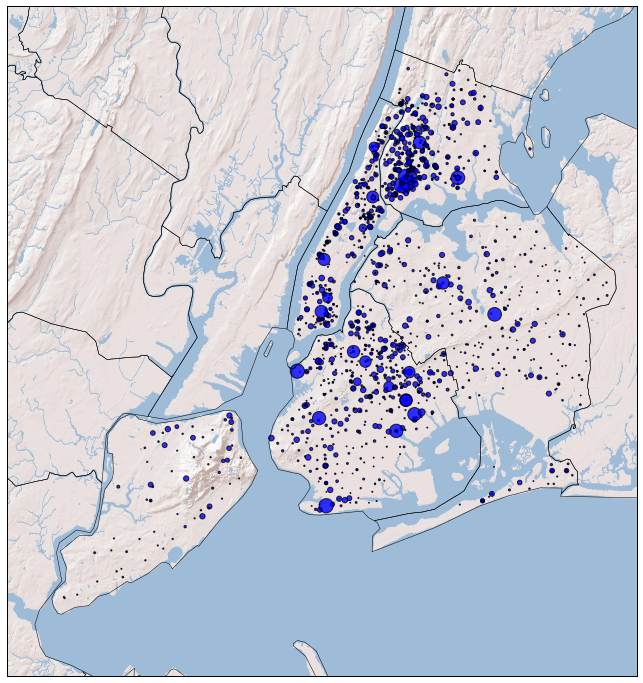

In [97]:
##Recall LCGGEOY is lat, LCGGEOX is long

def NYC_poverty_scatter(ax=None, lllat=40.45, urlat=40.95, lllon=-74.3, urlon=-73.68, year=2010):
    data = all_years_data[year]
    
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111)
    #Create basemap instance
    m = Basemap(ax = ax, 
               lon_0=(urlon + lllon)/2,
               lat_0=(urlat + lllat)/2,
               llcrnrlat=lllat, urcrnrlat=urlat,
               llcrnrlon=lllon, urcrnrlon=urlon,
               resolution='f', epsg=3857)
    #http://server.arcgisonline.com/arcgis/rest/services
    m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)
    m.drawcounties(linewidth=0.5)
    
    ##add points and color bar
    schools = m.scatter(data['LCGGEOX'].values, data['LCGGEOY'].values, latlon=True, s=data['Contracted_Instructional_Services'].values*1000, alpha=0.8, cmap='cool')
    
    return m

NYC_poverty_scatter()

Teachers 0.0481244278576
Instructional_Support_Srcs_All_Funds 0.0450845414701
Classroom_Instruction_All_Funds 0.0449908265596
Related_Services 0.0425500700773
Building_Services_All_Funds 0.0399329291332
Leases 0.0371732648574
LeadershipSupervisionSupport_All_Funds 0.0356379766763
Ancillary_Support_Services_All_Funds 0.0289512102529
Transportation 0.0237753344416
Contracted_Instructional_Services 0.0217865673889


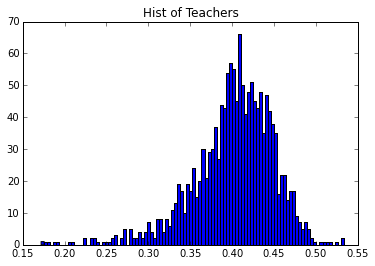

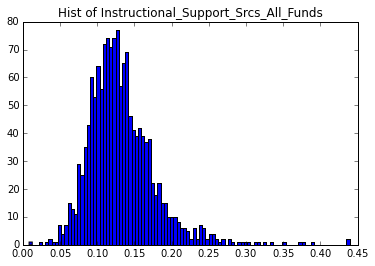

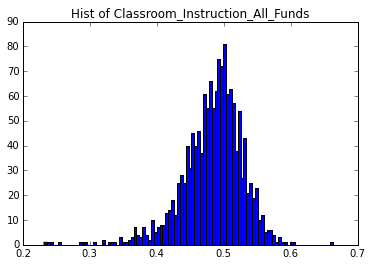

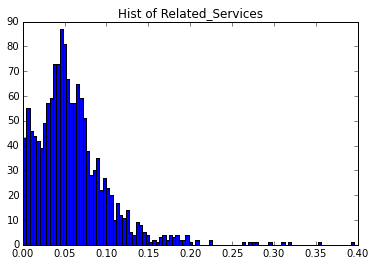

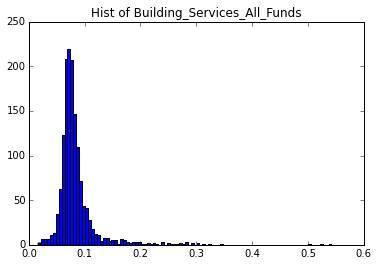

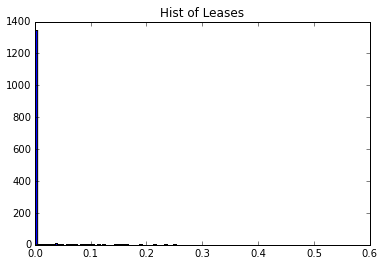

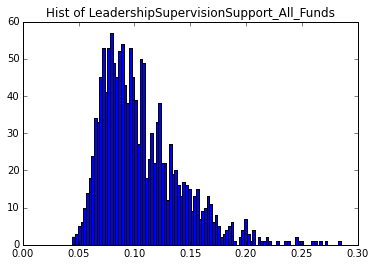

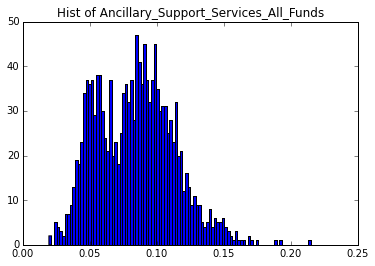

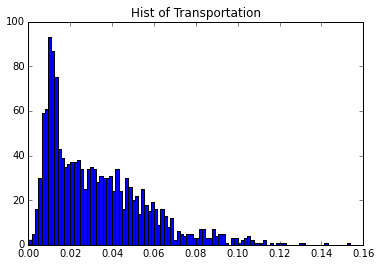

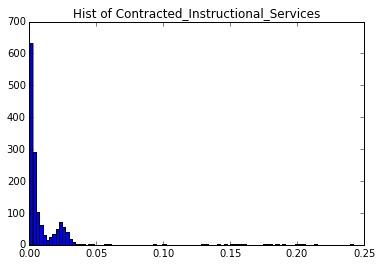

In [95]:
for feature in list(all_years_data[2010].std().order(ascending=False)[18:28].index):
    print feature, all_years_data[2010][feature].std()
    plt.figure()
    plt.hist(all_years_data[2010][feature], bins=100)
    plt.title('Hist of {}'.format(feature))